# **Introduction**
The finals for this course involves using a Deep learning algorithm on desired dataset. I have chosen to go ahead with IMDB movie reviews' sentiment analysis. The dataset contains 50K reviews and their sentiment. This data can be used to train the model and predict its accuracy.
The dataset can be found on kaggle at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Since this data is text based, Natural Language Processing algorithms will prove to be effective. The complete process will require first analysing the dataset, preprocessing, encode text data to numbers and then choosing a model. The model is then trained on the input using various hyper-parameters and finally an algorithm with selected hyperparameters is chosen to find the model's accuracy.
For inspiration, I went through this article that listed various approaches to tackle sentiment analysis using NLP and Deep Learning machine learning algorithms.

https://onlinelibrary.wiley.com/doi/full/10.1155/2021/5536560


In [1]:
#import libraries & packages
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
import gensim

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,Dense,Dropout,LSTM,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers  import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# **Data Analysis and Preprocessing**

In [2]:
# load the dataset
WORKING_DIR = '/content/drive/MyDrive/FinalsDL'
df = pd.read_csv(WORKING_DIR + "/IMDB Dataset.csv")

In [3]:
# inspect datatypes and get the rows and counts
print(df.dtypes)
print(df.shape)

review       object
sentiment    object
dtype: object
(50000, 2)


In [4]:
# inspect first 5 rows of the dataset
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# inspect a random row
df['review'][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

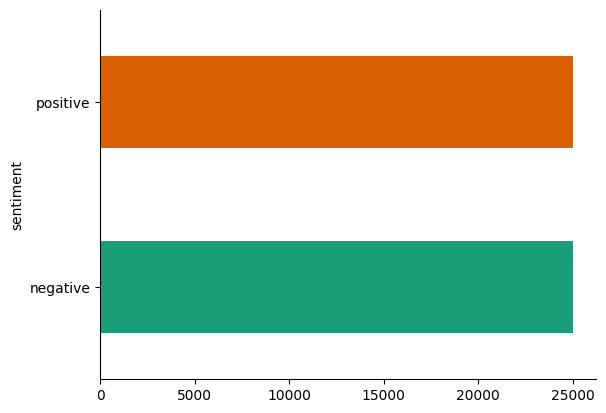

In [6]:
# check the sentiment split
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Th plot shows there are almost equal amount of records for both the sentiment types. If the dataset was skewed, we would have been limited to fewer records to create a well trained model.

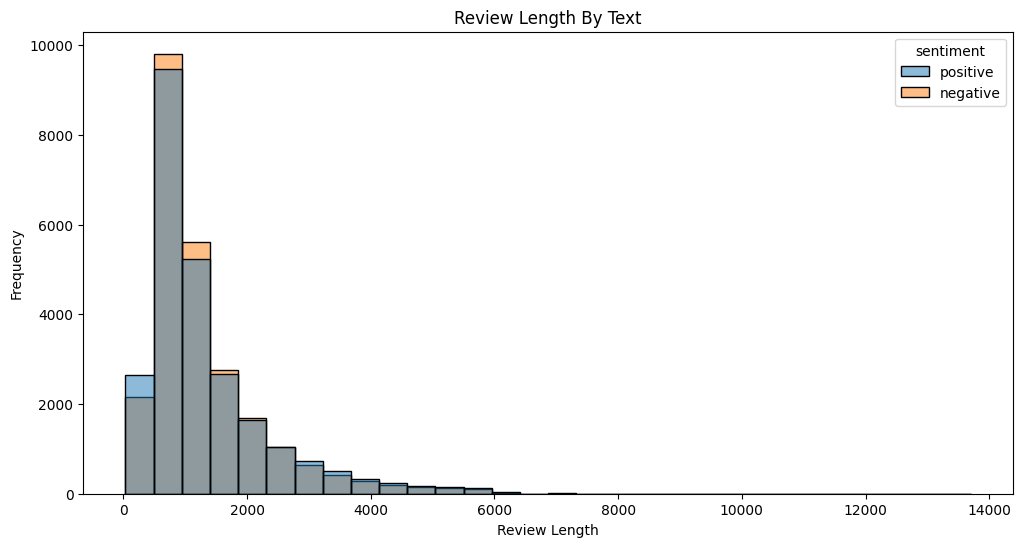

In [7]:
# Calculate the length of each review
df['length'] = df['review'].apply(len)

custom_palette = {0: "green", 1: "blue"}
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='sentiment', bins=30)
plt.title('Review Length By Text')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
df.isnull().values.any()

False

The above query shows that we have a clean dataset with no missing records.

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# routine to remove html tags
tag = re.compile(r'<[^>]+>')
def remove_tags(text):
  return tag.sub(' ', text)

In [11]:
# routine for pre-processing
def preprocess_data(text):
    text = text.lower()
    text = remove_tags(text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ',text)     # Delete URL
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # remove apostrophe
    text = re.sub(r'\s+',' ', text) # remove all single chars

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    return text

In [12]:
# remove URLs, some special characters, html tags, lower case all the texts and remove stopwords.
df['processed_review'] = df['review'].apply(preprocess_data)
df.head()

,review,sentiment,length,processed_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,748,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visually stunnin...


In [13]:
# convert categorical variable sentiment into numeric
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df.head()

,review,sentiment,length,processed_review
0,One of the other reviewers has mentioned that ...,1,1761,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,998,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,748,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,petter mattei love time money visually stunnin...


In [14]:
# retrieve the length of largest review.
max_length_review=-0
for i,review in enumerate(df['processed_review']):
    tokens=review.split()
    if(len(tokens)>max_length_review):
        max_length_review=len(tokens)
print(max_length_review)

1407


I have planned to use Keras Tokenizer to convert text to numbers. It is one of the ways of deriving the word embedding vectors. These are different from TF-IDF and Bag of Words in the sense that they maintain semantic relationship between the words.

In [15]:
# create word embedding
tok = Tokenizer()
tok.fit_on_texts(df['processed_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['processed_review'])
print(vocab_size)

99116


In [16]:
max_rev_len=1407  # max length of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [17]:
# add padding to have a maximum length
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='pre')
pad_rev.shape

pad_rev[3]

array([   0,    0,    0, ...,  502, 3165, 2590], dtype=int32)

Based on various runs of the model, I have finally come up with below parameters to get optimum results from the model.

* embedding_vector_features = 200. This is the number of features against which the Embedded layer starts working on the input.
* lstm_neurons_count = 150. This is the number of neurons in the LSTM layer.
* dropout_percent = 0.2. This is the percent of dropouts to set some inputs to 0, to avid overfitting.
* activation = 'sigmoid'. Since we are using classification, the most suitable activation function is Sigmoid.

The model was created with 1 Embedding, followed by a Dropout layer with 20% rate. This was followed by 1 LSTM layer with neurons count. = 200. And finally a Dense layer to transform the input into a binary classification output.

The optimization parameters used
- Binary CrossEntropy for loss
- Adam optimizer with learning rate of 10^-5. It was observed that for lower values of learning rate, the model was overfitting.


Accuracy metrics was used to evaluate the model.

In [18]:
embedding_vector_features = 200
lstm_neurons_count = 150
dropout_percent = 0.2
activation = 'sigmoid'
loss_fn = 'binary_crossentropy'

In [32]:
def create_Bi_RNN():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vector_features))
    model.add(Dropout(dropout_percent))
    model.add(Bidirectional(LSTM(units=lstm_neurons_count, return_sequences=True)))
    model.add(Dropout(dropout_percent))
    model.add(Dense(units=1, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
    model.summary()
    return model

model = create_Bi_RNN()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         19823200  
                                                                 
 dropout_4 (Dropout)         (None, None, 200)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 300)         421200    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, None, 300)         0         
                                                                 
 dense_3 (Dense)             (None, None, 1)           301       
                                                                 
Total params: 20244701 (77.23 MB)
Trainable params: 20244701 (77.23 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [20]:
def create_rnn_model(evf, lstm_neurons_count, dropout_percent, activation, loss, metrics):
    model = Sequential()
    model.add(Embedding(vocab_size, evf))
    model.add(Dropout(dropout_percent))
    model.add(LSTM(lstm_neurons_count))
    model.add(Dropout(dropout_percent))
    model.add(Dense(1,activation=activation))
    model.compile(loss=loss, optimizer=Adam(1e-5),metrics =['accuracy'])
    print(model.summary())
    return model

rnn_model = create_rnn_model(embedding_vector_features, lstm_neurons_count, dropout_percent, activation,loss_fn,['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         19823200  
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               210600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 20033951 (76.42 MB)
Trainable params: 20033951 (76.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Perform 80:20 split between train and test data.

In [21]:
y= df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(pad_rev,y,test_size=0.20,random_state=22)

In [22]:
X_train.shape, y_train.shape

((40000, 1407), (40000,))

In [23]:
# create a callback to stop early that monitors losses.
callback = EarlyStopping(monitor='loss', patience=3)

fit regular model

In [33]:
history = model.fit(X_train,y_train, epochs=10,batch_size=500,validation_data=(X_test,y_test),callbacks=[callback])

Epoch 1/10
80/80 [==============================] - 100s 1s/step - loss: 7.6296 - accuracy: 0.4997 - val_loss: 7.6048 - val_accuracy: 0.5013
Epoch 2/10
80/80 [==============================] - 89s 1s/step - loss: 7.6296 - accuracy: 0.4997 - val_loss: 7.6048 - val_accuracy: 0.5013
Epoch 3/10
80/80 [==============================] - 85s 1s/step - loss: 7.6296 - accuracy: 0.4997 - val_loss: 7.6048 - val_accuracy: 0.5013
Epoch 4/10
80/80 [==============================] - 85s 1s/step - loss: 7.6296 - accuracy: 0.4997 - val_loss: 7.6048 - val_accuracy: 0.5013


fit RNN model

In [25]:
# fit the model
rnn_history = rnn_model.fit(X_train,y_train, epochs=10,batch_size=500,validation_data=(X_test,y_test),callbacks=[callback])

Epoch 1/10
80/80 [==============================] - 44s 515ms/step - loss: 0.6930 - accuracy: 0.5073 - val_loss: 0.6926 - val_accuracy: 0.5353
Epoch 2/10
80/80 [==============================] - 43s 541ms/step - loss: 0.6924 - accuracy: 0.5403 - val_loss: 0.6920 - val_accuracy: 0.5727
Epoch 3/10
80/80 [==============================] - 41s 507ms/step - loss: 0.6915 - accuracy: 0.5811 - val_loss: 0.6911 - val_accuracy: 0.6114
Epoch 4/10
80/80 [==============================] - 43s 540ms/step - loss: 0.6902 - accuracy: 0.6231 - val_loss: 0.6896 - val_accuracy: 0.6474
Epoch 5/10
80/80 [==============================] - 42s 523ms/step - loss: 0.6878 - accuracy: 0.6679 - val_loss: 0.6859 - val_accuracy: 0.6948
Epoch 6/10
80/80 [==============================] - 43s 543ms/step - loss: 0.6707 - accuracy: 0.7259 - val_loss: 0.6371 - val_accuracy: 0.6833
Epoch 7/10
80/80 [==============================] - 46s 578ms/step - loss: 0.6098 - accuracy: 0.7545 - val_loss: 0.5884 - val_accuracy: 0.7960

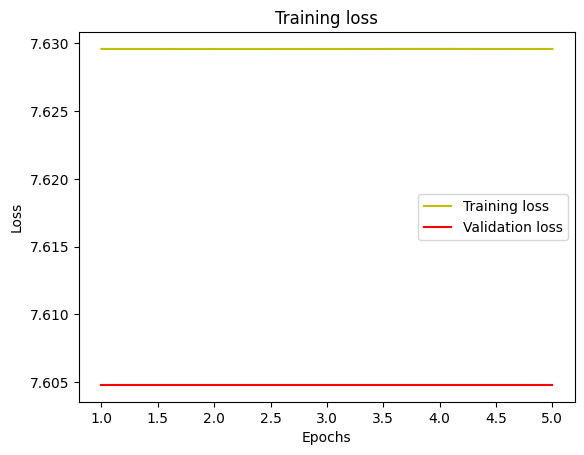

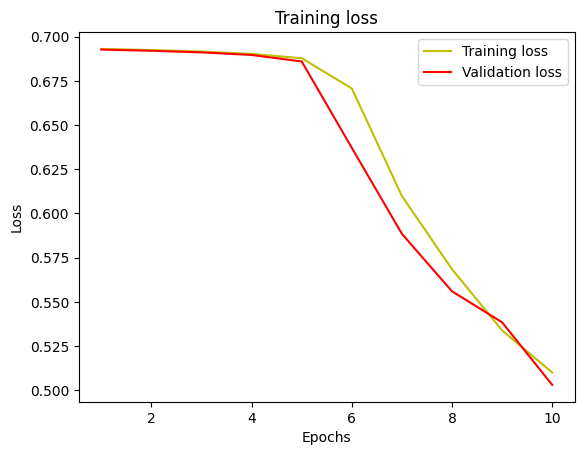

In [26]:
# create a chart for training and validation loss.
def draw_loss_plot(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


draw_loss_plot(history)
draw_loss_plot(rnn_history)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred_rnn = (rnn_model.predict(X_test) > 0.5).astype("int32")

In [35]:
print('Confusion Matrix for Bidirectional RNN')
print(confusion_matrix(y_test,y_pred[:, 0]))

print('Confusion Matrix for LSTM')
print(confusion_matrix(y_test,y_pred_rnn[:, 0]))

Confusion Matrix for Bidirectional RNN
[[   0 4987]
 [   0 5013]]
Confusion Matrix for LSTM
[[4191  796]
 [ 852 4161]]


In [38]:
# accuracy_score(y_pred, y_test)
accuracy_score(y_pred_rnn, y_test)

0.8352

# **Summary**

For the Sentiment Analysis on IMDB movies reviews of 50,000 records, I used Bidorectional LSTM and Simple LSTM. It shows that where Bidirectional LSTM ends up giving poor accuracy, LSTM achieves about 84 accuracy. The LSTM loss plot also shows that there's no underfitting or overfitting during model validation.
